In [1]:
import copy
from keys import Keys
from load_data import load_all_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import datetime

data = load_all_data()

Average Temperature vs time 

In [2]:
def is_full_year_data(year_dates):
    # check if each month has a data point
    return len(np.unique([date.month for date in year_dates])) == 12

def get_temperature_statistics(year_dates,year_temperatures):
    # return mean and std.
    months_temperatures = np.full(12,np.nan)
    for month in range(1,13):
        months_temperatures[month-1] = np.mean([year_temperatures[i] for i,date in enumerate(year_dates) if date.month == month])
    return np.mean(months_temperatures), np.std(months_temperatures)

In [3]:
year_avr_temperatures = {k:[] for k in np.unique(data[Keys.name])}
year_std_temperatures = {k:[] for k in np.unique(data[Keys.name])}
year_numbers = list(range(1900,2023))
for name in year_avr_temperatures:
    for year in year_numbers:
        year_start = datetime.datetime(year=year,month=1,day=1,hour=0,minute=0,second=0)
        year_end = datetime.datetime(year=year+1,month=1,day=1,hour=0,minute=0,second=0)
        indexes_year_station = (year_start < data[Keys.date] ) * (data[Keys.date] < year_end)
        indexes_year_station *= data[Keys.name] == name
        year_dates = data[Keys.date][indexes_year_station]
        year_temperatures = data[Keys.temperature][indexes_year_station]
        if is_full_year_data(year_dates):
            avr_temp,temp_std = get_temperature_statistics(year_dates,year_temperatures)
        else:
            avr_temp,temp_std = np.nan,np.nan
        year_avr_temperatures[name].append(avr_temp)
        year_std_temperatures[name].append(temp_std)
    year_avr_temperatures[name] = np.array(year_avr_temperatures[name])
    year_std_temperatures[name] = np.array(year_std_temperatures[name])

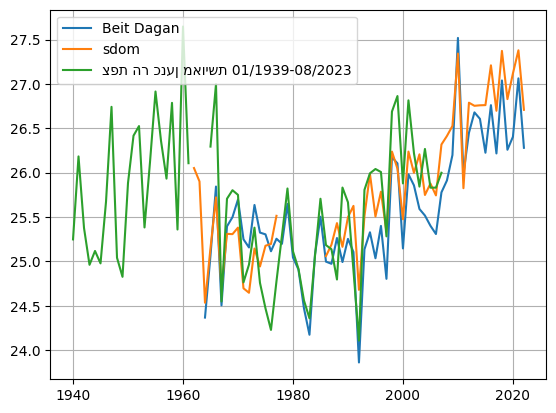

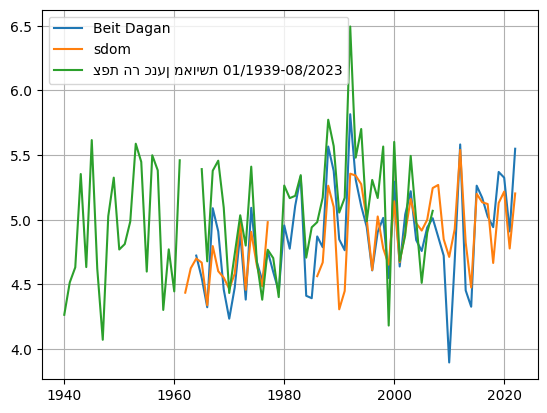

In [4]:
year_avr_temperatures_cpy = copy.deepcopy(year_avr_temperatures)
names = list(year_avr_temperatures.keys())
year_avr_temperatures_cpy[names[1]] += -5
year_avr_temperatures_cpy[names[2]] += 5
for name in year_avr_temperatures_cpy:
    plt.plot(year_numbers,year_avr_temperatures_cpy[name],label=name)
plt.legend()
# plt.ylim(23,30)
plt.grid()

plt.figure()
year_std_temperatures_cpy = copy.deepcopy(year_std_temperatures)
names = list(year_std_temperatures.keys())
year_std_temperatures_cpy[names[1]] += -2
year_std_temperatures_cpy[names[2]] += -2.5
for name in year_std_temperatures_cpy:
    plt.plot(year_numbers,year_std_temperatures_cpy[name],label=name)
plt.legend()
# plt.ylim(3.5,7)
plt.grid()

Percentage Of Hot Days

In [5]:
def percent_days_over_hot(year_temperatures,hot):
    return np.sum(year_temperatures > hot) / len(year_temperatures)

def percent_days_under_cold(year_temperatures,cold):
    return np.sum(year_temperatures < cold) / len(year_temperatures)
    

In [6]:
def get_percentage_of_extreme_days(hot, years, names, b_measuring_hot_days):
    if type(names) != list:
        names = [names]
    percentage_array = {k:[] for k in names}
    for name in percentage_array:
        for year in years:
            year_start = datetime.datetime(year=year,month=1,day=1,hour=0,minute=0,second=0)
            year_end = datetime.datetime(year=year+1,month=1,day=1,hour=0,minute=0,second=0)
            indexes_year = (year_start < data[Keys.date] ) * (data[Keys.date] < year_end)
            indexes_year *= data[Keys.name] == name
            year_dates = data[Keys.date][indexes_year]
            year_temperatures = data[Keys.temperature][indexes_year]
            if is_full_year_data(year_dates):
                if b_measuring_hot_days:
                    percentage = percent_days_over_hot(year_temperatures,hot)
                else:
                    percentage = percent_days_under_cold(year_temperatures,hot)
            else:
                percentage = np.nan
            percentage_array[name].append(percentage)
    return percentage_array

In [7]:
def extremum_vs_time_bar_plot(temperatures, name,b_measuring_hot_days):
    plt.figure()
    for hot in temperatures:
        p_hot_array = get_percentage_of_extreme_days(hot,year_numbers,names,b_measuring_hot_days)
        p_hot_array_cp = copy.deepcopy(p_hot_array)
        window_size = 2
        a = np.concatenate([np.full(100,p_hot_array_cp[name][0]),p_hot_array_cp[name],np.full(100,p_hot_array_cp[name][-1])])
        mask = np.ones(window_size)
        a = np.convolve(a,mask/np.sum(mask),mode="same")[100:-100]
        a = a[::window_size]
        b = year_numbers[::window_size]
        if b_measuring_hot_days:
            plt.bar(b,a*100,width=window_size*0.9,label=f"above {hot}°C")
        else:
            plt.bar(b,a*100,width=window_size*0.9,label=f"below {hot}°C")
        # plt.plot(year_numbers,np.array(p_hot_array_cp[name])*100,"o",label=f"{hot}")
        plt.legend(loc="upper left")
        # plt.xlim(2020,2024)
        plt.grid()
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
        # plt.yscale("log")
        if b_measuring_hot_days:
            plt.title(f"number of hot days versus year, in {name}")
        else:
            plt.title(f"number of cold days versus year, in {name}")
        plt.ylabel("percent of the year")

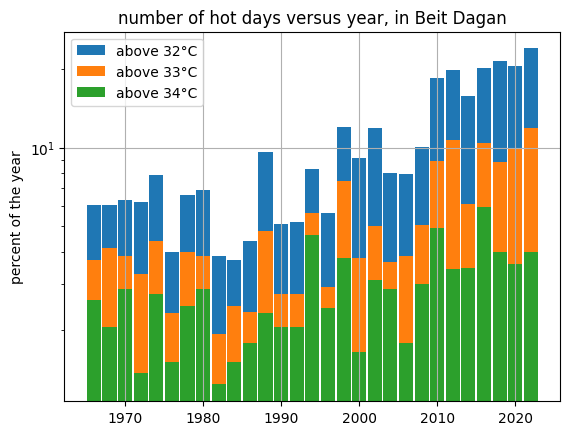

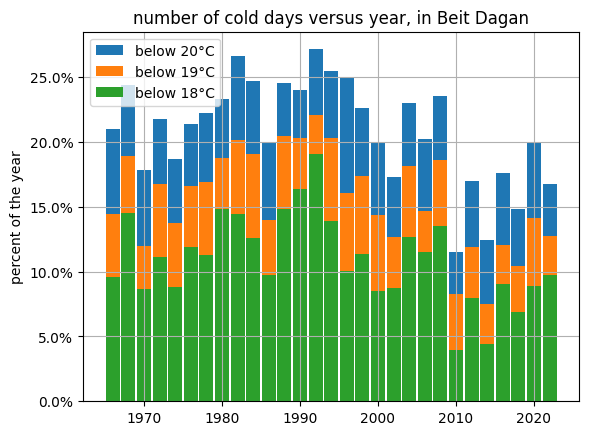

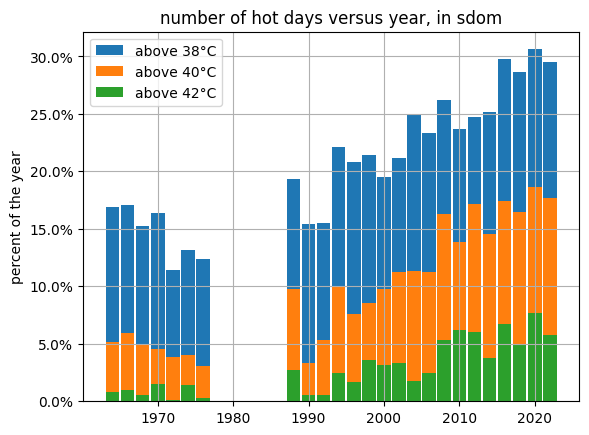

In [20]:
extremum_vs_time_bar_plot([32,33,34],names[0],True)
extremum_vs_time_bar_plot([32,33,34],names[0],True)
plt.yscale("log")
extremum_vs_time_bar_plot([20,19,18],names[0],False)
extremum_vs_time_bar_plot([38,40,42],names[1],True)
# extremum_vs_time_bar_plot([30,31,32],names[2],True)

2019 - 2022 comparison to 1970 - 1990

In [23]:
def draw_temperature_distribution(name,temperature_min,temperature_max):
    plt.figure()
    temperatures = np.arange(temperature_min,temperature_max,0.1)
    p_hot_arrays = []
    for years in [list(range(1970,1991)),list(range(2013,2017)),list(range(2019,2023))]:
        p_hot_array = [np.nanmean(get_percentage_of_extreme_days(hot,years,name,False)[name]) for hot in temperatures]
        p_hot_array = np.gradient(p_hot_array)/0.1
        window_size = 10
        p_hot_array = np.concatenate([np.full(100,p_hot_array[0]),p_hot_array,np.full(100,p_hot_array[-1])])
        mask = np.ones(window_size)
        p_hot_array = np.convolve(p_hot_array,mask/np.sum(mask),mode="same")[100:-100]
        p_hot_arrays.append(p_hot_array)
        plt.plot(temperatures,p_hot_array,label=f"{min(years)}-{max(years)}")
    plt.legend()
    plt.title(f"probability density of temperature for different time intervals\n{name}")
    plt.xlabel("temperature °C")
    plt.ylabel("probability density")

C:\Users\TIFFANY\AppData\Local\Temp\ipykernel_10960\219711996.py:6: RuntimeWarning: Mean of empty slice
  p_hot_array = [np.nanmean(get_percentage_of_extreme_days(hot,years,name,False)[name]) for hot in temperatures]


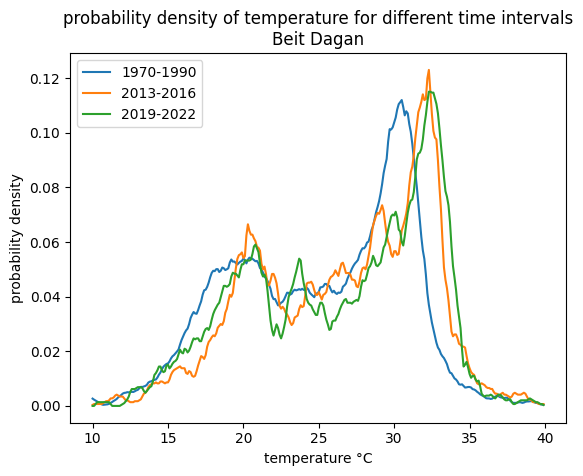

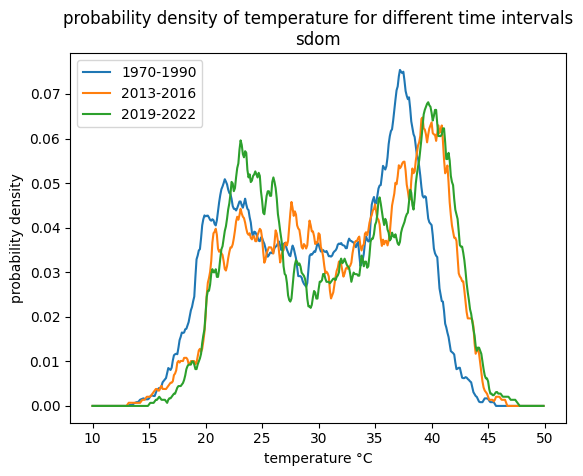

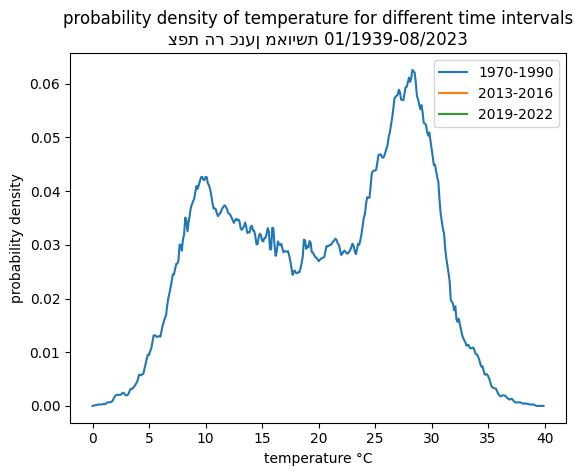

In [24]:
draw_temperature_distribution(names[0],10,40)
draw_temperature_distribution(names[1],10,50)
draw_temperature_distribution(names[2],0,40)

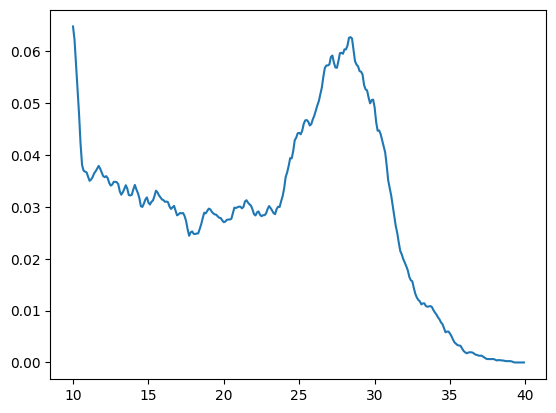

In [19]:
plt.plot(temperatures,p_hot_arrays[0])
plt.plot(np.array(temperatures)-1.8,np.array(p_hot_arrays[1]))